In [1]:
%matplotlib inline

In [2]:
from pyshake.shakelib.source import Source
import numpy as np
import matplotlib.pyplot as plt
import StringIO
from openquake.hazardlib.gsim import base,abrahamson_2014
from openquake.hazardlib.geo import Mesh
from openquake.hazardlib.geo.surface.planar import PlanarSurface
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def mycolorbar(mappable,ax=None,cax=None):
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mappable,ax=ax, cax=cax)

In [4]:
fault_text = """
30.0 175.0 5
32.0 175.0 5
32.0 177.0 15
30.0 177.0 15
30.0 175.0 5
"""
event_text = """<?xml version="1.0" encoding="US-ASCII" standalone="yes"?>
<earthquake id="test" lat="31.0" lon="176.0" mag="7.9" year="2015" month="01" day="01" hour="01" minute="01" second="01" timezone="GMT" depth="12.0" locstring="EASTERN SICHUAN, CHINA" created="1211173621" otime="1210573681" type="" />
"""
source_text = """mech=RS"""
ffile = StringIO.StringIO(fault_text)
efile = StringIO.StringIO(event_text)
sfile = StringIO.StringIO(source_text)
source = Source.readFromFile(efile,faultfile=ffile,sourcefile=sfile)
gmpe = abrahamson_2014.AbrahamsonEtAl2014()
rupture = source.getRuptureContext(gmpe)
mapwidth = 2.0
latmin = rupture.hypo_lat - mapwidth
latmax = rupture.hypo_lat + mapwidth
lonmin = rupture.hypo_lon - mapwidth
lonmax = rupture.hypo_lon + mapwidth
dim = 0.02
lats = np.arange(latmin,latmax,dim)
lons = np.arange(lonmin,lonmax,dim)
lon,lat = np.meshgrid(lons,lats)
dep = np.zeros_like(lon)
mesh = Mesh(lon,lat,dep)
distances = source.getDistanceContext(gmpe,mesh)

Calculating method rx
Calculating method rjb
Calculating method ry0
Calculating method rrup


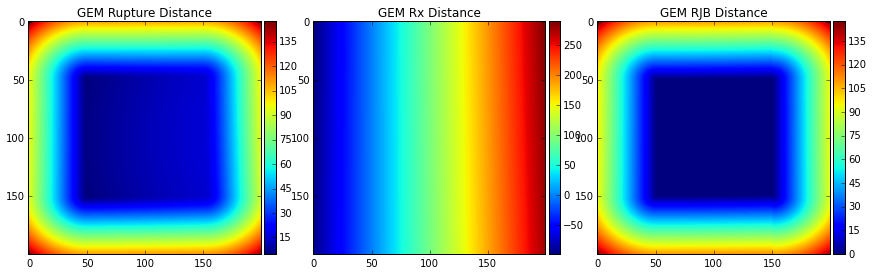

In [5]:
topLeft,topRight,bottomRight,bottomLeft = source.getQuadrilaterals()[0]
topRight.depth = topLeft.depth
bottomRight.depth = bottomLeft.depth
bottomRight.latitude = topRight.latitude
bottomRight.longitude = bottomLeft.longitude

ps = PlanarSurface.from_corner_points(0.02,topLeft,topRight,bottomRight,bottomLeft)
rupdist = ps.get_min_distance(mesh)
rjbdist = ps.get_joyner_boore_distance(mesh)
rxdist = ps.get_rx_distance(mesh)
#rydist = ps.get_ry0_distance(mesh)

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,6))
fig.tight_layout()
map1 = ax1.imshow(rupdist);mycolorbar(map1,ax=ax1);
ax1.set_title('GEM Rupture Distance');

map2 = ax2.imshow(rxdist);mycolorbar(map2,ax=ax2);
ax2.set_title('GEM Rx Distance');

map3 = ax3.imshow(rjbdist);mycolorbar(map3,ax=ax3);
ax3.set_title('GEM RJB Distance');

# plt.figure(figsize=(8,8)),
# plt.imshow(rydist);plt.colorbar();
# plt.title('GEM Ry0 Distance');

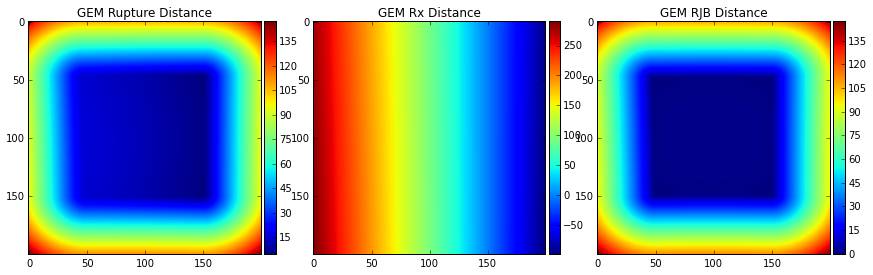

In [6]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,6))
fig.tight_layout()
map1 = ax1.imshow(distances.rrup);mycolorbar(map1,ax=ax1);
ax1.set_title('GEM Rupture Distance');

map2 = ax2.imshow(distances.rx);mycolorbar(map2,ax=ax2);
ax2.set_title('GEM Rx Distance');

map3 = ax3.imshow(distances.rjb);mycolorbar(map3,ax=ax3);
ax3.set_title('GEM RJB Distance');

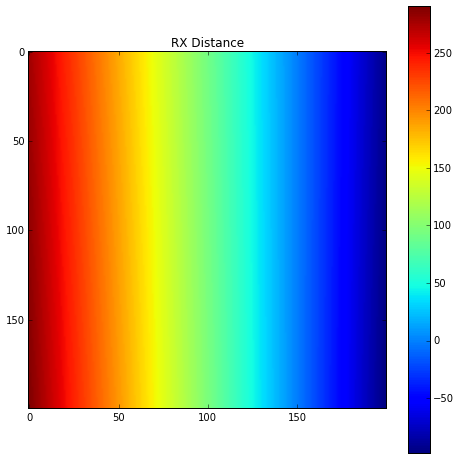

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(distances.rx)
plt.title('RX Distance')
plt.colorbar();

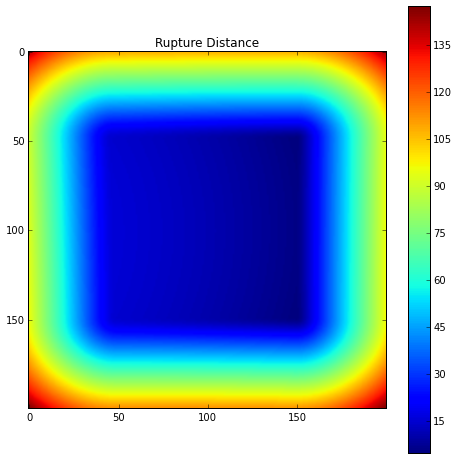

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(distances.rrup)
plt.title('Rupture Distance')
plt.colorbar();

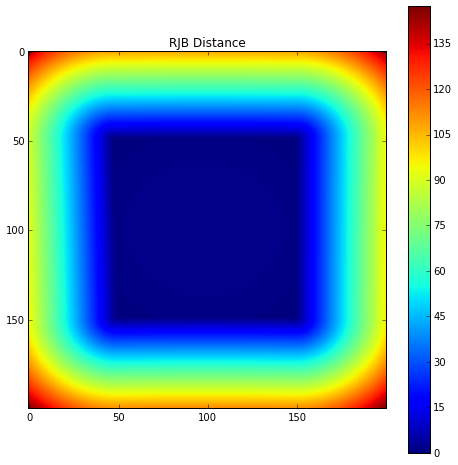

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(distances.rjb)
plt.title('RJB Distance')
plt.colorbar();

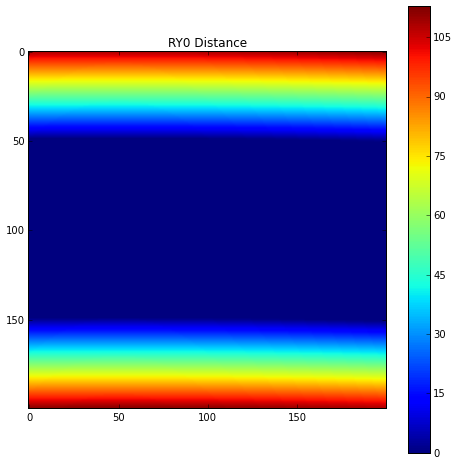

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(distances.ry0)
plt.title('RY0 Distance')
plt.colorbar();

In [11]:
rupture = source.getRuptureContext(gmpe)
for key in rupture.__slots__:
    try:
        value = eval('rupture.%s' % key)
    except:
        print 'No value set for %s' % key
        continue
    print '%s = %s' % (key,str(value))

mag = 7.9
strike = 0.0
dip = 86.9690530225
rake = 90.0
ztor = 4.99999999992
hypo_lon = 176.0
hypo_lat = 31.0
hypo_depth = 12.0
width = 192.910363988
No value set for hypo_loc
